## Analyzing movie rentals

In this notebook, I connect to a PostgreSQL database with some sample data about a DVD rental business after which I analyze and visualize the data in python.

Below is the structure of the database (taken from [here](https://www.postgresqltutorial.com/postgresql-sample-database/)).

<img src='dvd-rental-sample-database-diagram.png'>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
from sqlalchemy import create_engine
from secrets import *
import warnings

# visualization settings
from ipywidgets import interact
%config InlineBackend.figure_format='retina'
plt.rcParams['figure.figsize'] = (14, 6)
plt.style.use('seaborn-darkgrid')

warnings.filterwarnings('ignore')

In [2]:
db_string = f'postgresql+psycopg2://{USER}:{PASSWORD}@{HOST}/{DBNAME}'
engine = create_engine(db_string)

In [3]:
with engine.connect() as con:
    df = pd.read_sql_query("""SELECT COUNT(*) FROM actor""", con)
    
df.head()

,count
0,200


In [4]:
with engine.connect() as con:
    film_rental = pd.read_sql_query(
    """
        SELECT 
        film.title AS film_title, 
        category.name AS genre,
        length,
        rating,
        SUBSTRING(rental_date::VARCHAR,1,10)::TIMESTAMP AS rental_date,
        SUBSTRING(return_date::VARCHAR,1,10)::TIMESTAMP AS return_date,
        film.rental_duration AS rental_duration
        FROM rental
        INNER JOIN inventory USING(inventory_id)
        INNER JOIN film USING(film_id)
        INNER JOIN film_category USING(film_id)
        INNER JOIN category USING(category_id)
    """, con)
    
engine.connect().close()

display(film_rental.head())

,film_title,genre,length,rating,rental_date,return_date,rental_duration
0,Freaky Pocus,Music,126,R,2005-05-24,2005-05-28,7
1,Graduate Lord,Children,156,G,2005-05-24,2005-06-01,7
2,Love Suicides,Horror,181,R,2005-05-24,2005-06-03,6
3,Idols Snatchers,Children,84,NC-17,2005-05-24,2005-06-02,5
4,Mystic Truman,Comedy,92,NC-17,2005-05-24,2005-05-27,5


In [5]:
film_rental = (
    film_rental
        .dropna()
        .assign(duration_spent = lambda x : x.return_date - x.rental_date)
)

film_rental.duration_spent = (
    film_rental
        .duration_spent
        .astype(str)
        .str
        .split(' ', expand=True)[0]
        .astype(int)
)

display(film_rental.head())

,film_title,genre,length,rating,rental_date,return_date,rental_duration,duration_spent
0,Freaky Pocus,Music,126,R,2005-05-24,2005-05-28,7,4
1,Graduate Lord,Children,156,G,2005-05-24,2005-06-01,7,8
2,Love Suicides,Horror,181,R,2005-05-24,2005-06-03,6,10
3,Idols Snatchers,Children,84,NC-17,2005-05-24,2005-06-02,5,9
4,Mystic Truman,Comedy,92,NC-17,2005-05-24,2005-05-27,5,3


In [6]:
film_rental.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15861 entries, 0 to 16043
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   film_title       15861 non-null  object        
 1   genre            15861 non-null  object        
 2   length           15861 non-null  int64         
 3   rating           15861 non-null  object        
 4   rental_date      15861 non-null  datetime64[ns]
 5   return_date      15861 non-null  datetime64[ns]
 6   rental_duration  15861 non-null  int64         
 7   duration_spent   15861 non-null  int32         
dtypes: datetime64[ns](2), int32(1), int64(2), object(3)
memory usage: 867.4+ KB


In [7]:
film_rental.describe()

,length,rental_duration,duration_spent
count,15861.000000,15861.000000,15861.000000
mean,114.994578,4.937141,5.025219
std,40.114715,1.401637,2.611835
min,46.000000,3.000000,0.000000
25%,81.000000,4.000000,3.000000
50%,114.000000,5.000000,5.000000
75%,148.000000,6.000000,7.000000
max,185.000000,7.000000,10.000000


## Understanding the Variables

In [8]:
variables = pd.DataFrame(columns=['variable','data type','number of unique varibles','unique variables'])

for i, var in enumerate(film_rental.columns):
    variables.loc[i] = [var, film_rental[var].dtype, film_rental[var].nunique(), film_rental[var].unique().tolist() ]
    
variables

,variable,data type,number of unique varibles,unique variables
0,film_title,object,958,"[Freaky Pocus, Graduate Lord, Love Suicides, I..."
1,genre,object,16,"[Music, Children, Horror, Comedy, Animation, F..."
2,length,int64,140,"[126, 156, 181, 84, 92, 123, 56, 62, 109, 119,..."
3,rating,object,5,"[R, G, NC-17, PG-13, PG]"
4,rental_date,datetime64[ns],40,"[1116892800000000000, 1116979200000000000, 111..."
5,return_date,datetime64[ns],84,"[1117238400000000000, 1117584000000000000, 111..."
6,rental_duration,int64,5,"[7, 6, 5, 4, 3]"
7,duration_spent,int32,11,"[4, 8, 10, 9, 3, 5, 6, 1, 2, 0, 7]"


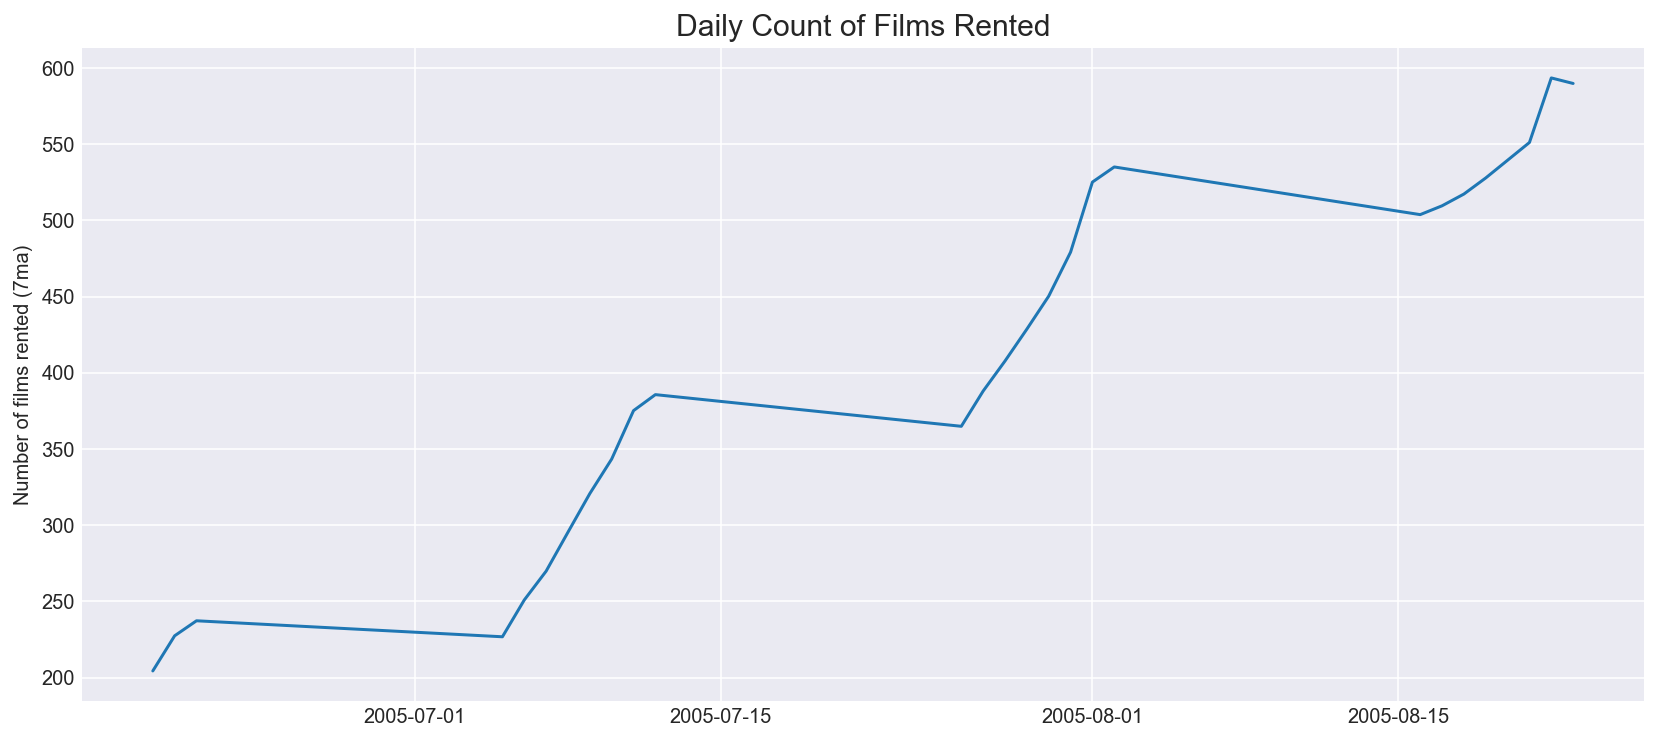

In [9]:
rental_count = (
        film_rental
            .groupby('rental_date')['film_title']
            .count()
            .reset_index()
            .rename(columns = {'film_title':'number_of_films_rented'})
            .assign(number_of_films_rented_7ma= lambda x : x['number_of_films_rented'].rolling(window=14).mean())
)

ax = sns.lineplot(data=rental_count, x='rental_date', y='number_of_films_rented_7ma')
ax.set_title('Daily Count of Films Rented',fontsize=15)
ax.set_ylabel('Number of films rented (7ma)')
ax.set_xlabel('')
plt.show()

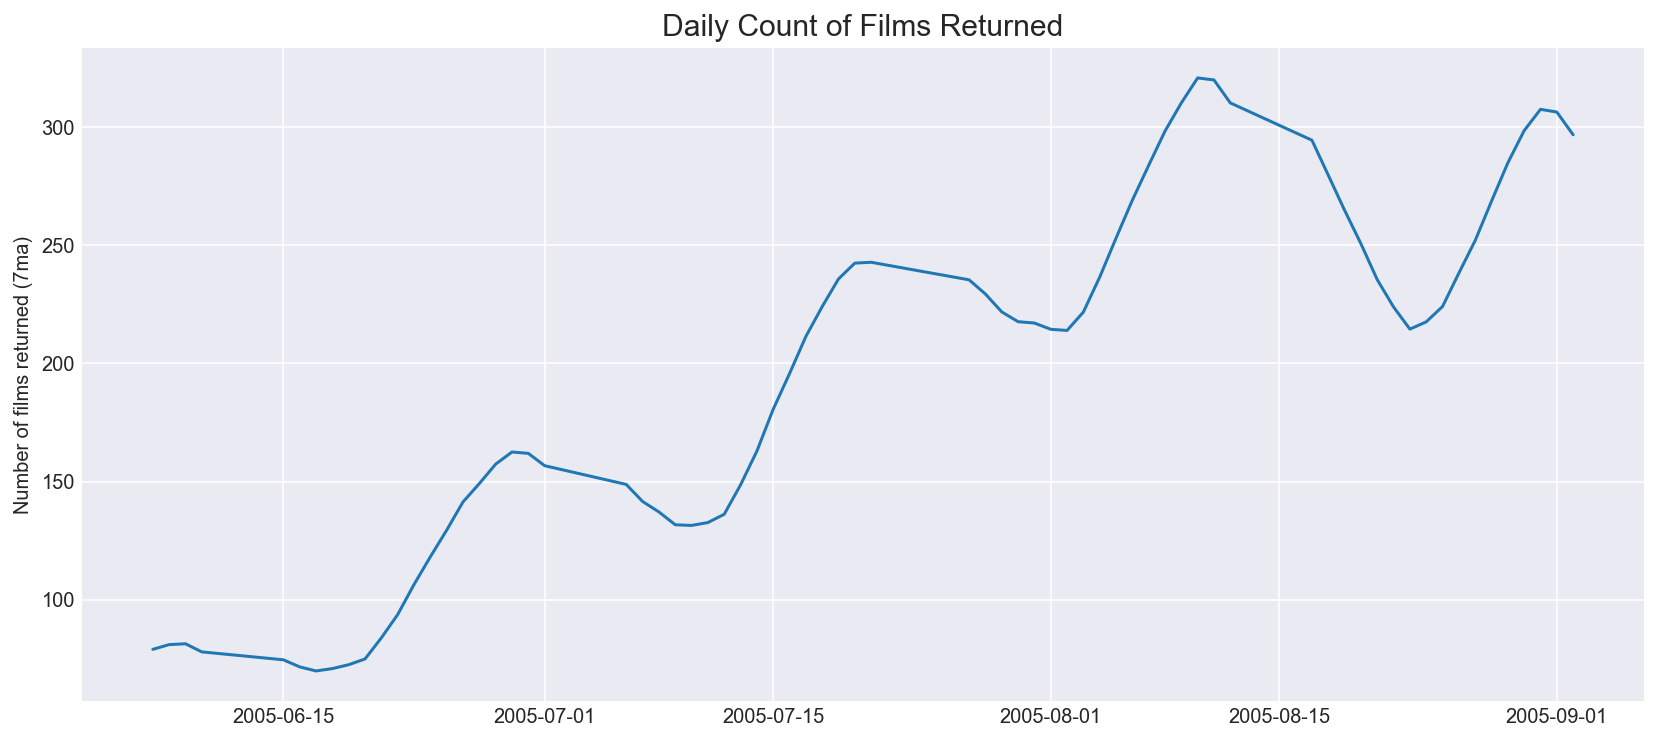

In [10]:
return_count = (
        film_rental
            .groupby('return_date')['film_title']
            .count()
            .reset_index()
            .rename(columns = {'film_title':'number_of_films_returned'})
            .assign(number_of_films_returned_7ma = lambda x : x['number_of_films_returned'].rolling(window=14).mean())
)
ax = sns.lineplot(data=return_count, x='return_date', y='number_of_films_returned_7ma')
ax.set_title('Daily Count of Films Returned',fontsize=15)
ax.set_ylabel('Number of films returned (7ma)')
ax.set_xlabel('')
plt.show()

In [11]:
# # Plot trend in the length of films over the years for each genre
# pd.options.plotting.backend='plotly'
# @interact(genre=film_rental.genre)
# def plot_trends(genre):
#     fig = (
#         film_rental
#             .query('genre == @genre')
#             .sort_values(by='rental_date')
#             .reset_index(drop=True)
#             .plot.line(x='rental_date', y='length', color='rating')
#     )
#     fig.update_layout(
#         title = f'Trend in Film Length for {genre} Movies',
#         xaxis_title = None,
#         yaxis_title = 'Length of Film'
#     )
#     return fig

Now let's split the data into two groups. Films that were returned `late` and those returned `early`. Ignoring the third group that was returned on the exact day it was due for return.

In [12]:
late_return = (
    film_rental
        .query('duration_spent > rental_duration')
        .assign(time_diff = lambda x : x.duration_spent - x.rental_duration)
)

late_return.head()

,film_title,genre,length,rating,rental_date,return_date,rental_duration,duration_spent,time_diff
1,Graduate Lord,Children,156,G,2005-05-24,2005-06-01,7,8,1
2,Love Suicides,Horror,181,R,2005-05-24,2005-06-03,6,10,4
3,Idols Snatchers,Children,84,NC-17,2005-05-24,2005-06-02,5,9,4
5,Swarm Gold,Horror,123,PG-13,2005-05-24,2005-05-29,4,5,1
8,Hanging Deep,Drama,62,G,2005-05-25,2005-05-31,5,6,1


In [13]:
early_return = (
    film_rental
        .query('duration_spent < rental_duration')
        .assign(time_diff = lambda x : x.rental_duration - x.duration_spent)
)

early_return.head()

,film_title,genre,length,rating,rental_date,return_date,rental_duration,duration_spent,time_diff
0,Freaky Pocus,Music,126,R,2005-05-24,2005-05-28,7,4,3
4,Mystic Truman,Comedy,92,NC-17,2005-05-24,2005-05-27,5,3,2
6,Lawless Vision,Animation,181,G,2005-05-24,2005-05-27,6,3,3
7,Matrix Snowman,Foreign,56,PG-13,2005-05-25,2005-05-28,6,3,3
10,Games Bowfinger,Travel,119,PG-13,2005-05-25,2005-05-30,7,5,2


What `genres` have the highest average `time difference` for each group (`early` & `late` return) ? Answering this question could help us assertain the genre of films customers enjoy watching or not. 

In [14]:
late_avg = (
        late_return
            .groupby(['genre'])['length','time_diff']
            .mean()
            .nlargest(columns='time_diff', n=10)
            .reset_index()
            .rename(columns={'length':'avg_length','time_diff':'avg_time_diff'})
)
late_avg

,genre,avg_length,avg_time_diff
0,New,107.715217,3.145652
1,Comedy,109.656951,2.899103
2,Sports,126.887564,2.894378
3,Documentary,111.768340,2.839768
4,Classics,111.526570,2.792271
5,Horror,112.203562,2.791349
6,Animation,109.536965,2.789883
7,Sci-Fi,101.964083,2.763705
8,Children,110.019802,2.757426
9,Action,109.629191,2.753452


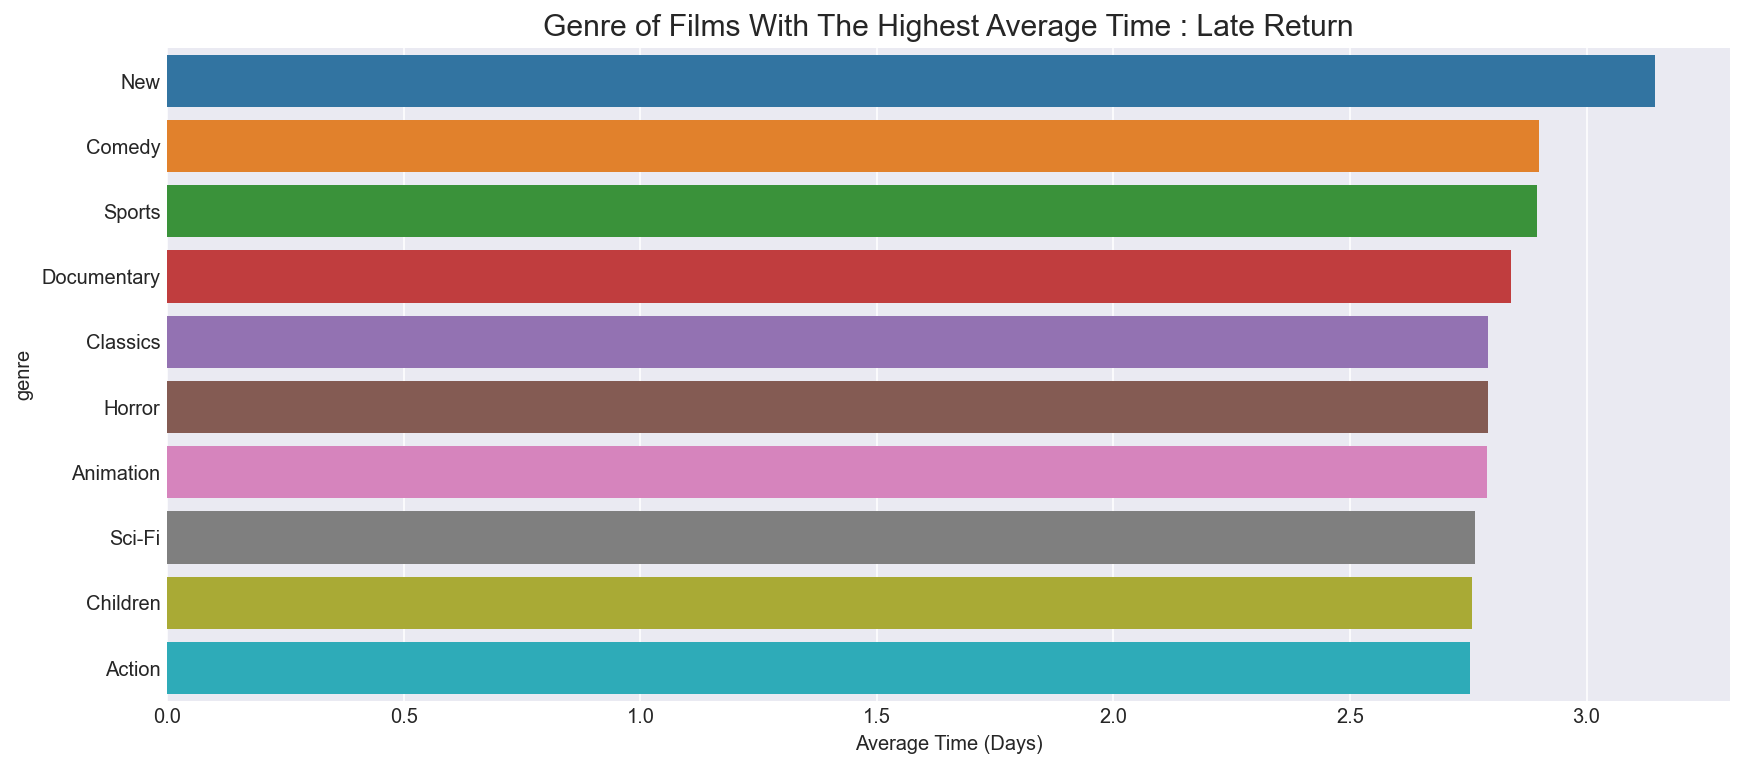

In [15]:
ax = sns.barplot(data=late_avg, y='genre', x='avg_time_diff')
ax.set_title('Genre of Films With The Highest Average Time : Late Return',fontsize=15)
ax.set_xlabel('Average Time (Days)')
plt.show()

In [16]:
early_avg = (
        early_return
            .groupby(['genre'])['length','time_diff']
            .mean()
            .nlargest(columns='time_diff', n=10)
            .reset_index()
            .rename(columns={'length':'avg_length','time_diff':'avg_time_diff'})
)
early_avg

,genre,avg_length,avg_time_diff
0,Travel,120.240741,3.057870
1,Family,111.077551,2.855102
2,Horror,114.600000,2.851429
3,Drama,123.332657,2.825558
4,Classics,114.209246,2.812652
5,Foreign,122.767742,2.793548
6,Children,113.110849,2.783019
7,Music,115.222812,2.748011
8,Games,130.375635,2.730964
9,Action,108.277895,2.726316


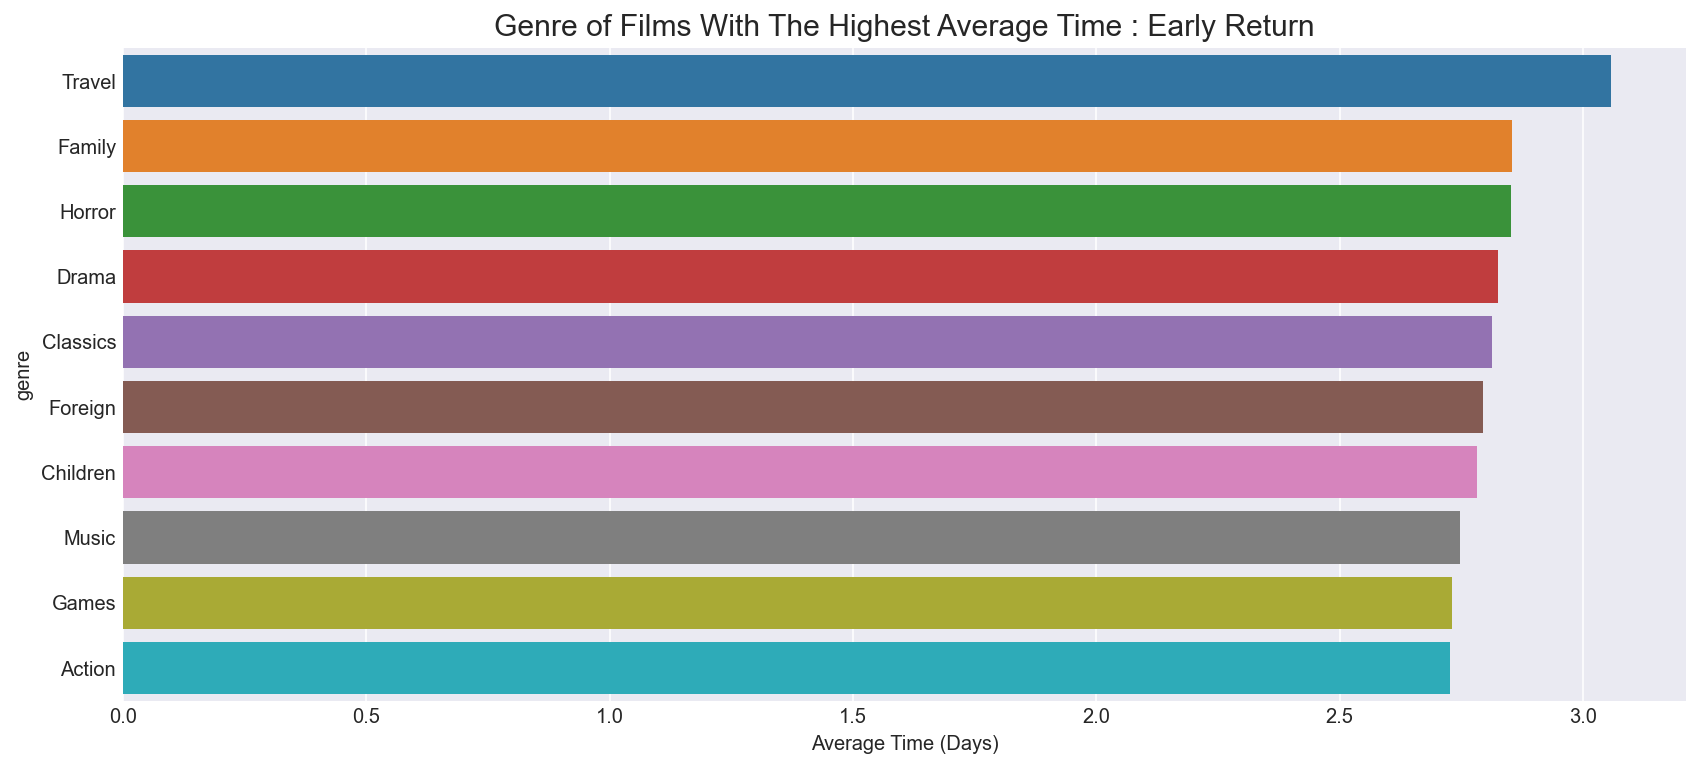

In [17]:
ax = sns.barplot(data=early_avg, y='genre', x='avg_time_diff')
ax.set_title('Genre of Films With The Highest Average Time : Early Return',fontsize=15)
ax.set_xlabel('Average Time (Days)')
plt.show()